In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import time
import tqdm
from tqdm.notebook import tqdm as notebooktqdm
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from PIL import Image
import timm
from timm.layers import BatchNormAct2d
import os
# from google.colab import files

In [2]:
# work place
work_dir = './'
os.chdir(work_dir)

In [3]:
class YoutubeDataset(Dataset):
    def __init__(self, data, doc2vec):
        self.ids = list(data['video_id'])
        self.titles = doc2vec # pretrained doc2vec features
        self.data = data # video_id, metadata, views(y) from csv file
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.image_encoder = timm.create_model('efficientnet_b1_pruned', features_only =True, pretrained=True)
        model = timm.create_model('efficientnet_b1_pruned', pretrained=True)
        data_cfg = timm.data.resolve_data_config(model.pretrained_cfg)
        self.transform = timm.data.create_transform(**data_cfg)

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        # index order of video_id, meta, y are same
        video_id = self.ids[idx]
        
        image = Image.open( work_dir+'medium_15287/{}.jpg'.format(video_id))
        image = self.transform(image)
        # image = torch.FloatTensor(np.array(image)).permute(2, 0, 1).unsqueeze(dim=0)
        self.image_encoder.eval()
        feature_map = self.image_encoder(torch.unsqueeze(image,0))[-1].squeeze() # (320,6,10)
        
        title = self.titles[video_id] # get video title
        title = torch.FloatTensor(np.array(title, dtype=np.float16))
        
        meta = torch.FloatTensor(self.data[['period_day', 'subscriber_count']].to_numpy()[idx]) # get metadata
        
        y = np.log10(self.data['views'].to_numpy() + 1) # add 1 for zero views
        y = np.expand_dims(y, axis=1) # add batch dimension
        y = torch.FloatTensor(y[idx]) # get log10(views+1) by idx value
        
        return video_id, feature_map, title, meta, y

In [4]:
# # add nomarlizing
# data = pd.read_csv('./train.csv')
# mean_period = data['period_day'].mean()
# std_period = data['period_day'].std()
# mean_sub = data['subscriber_count'].mean()
# std_sub = data['subscriber_count'].std()
# print(mean_period, std_period, mean_sub, std_sub)

# data['period_day'] = (data['period_day'] - mean_period)/std_period
# data['subscriber_count'] = (data['subscriber_count']-mean_sub)/std_sub

# train_data, valid_data = train_test_split(data, test_size = 0.1, random_state = 55)
# test_data = pd.read_csv('./test.csv')
# train_data = train_data[:1000]
# valid_data = valid_data[:100]
# test_data = test_data[:100]
# print('Train Dataset Size : ',len(train_data))
# print('Validation Dataset Size : ',len(valid_data))
# print('Test Dataset Size : ',len(test_data))

# data.head()

In [4]:
# upload
train_data = pd.read_csv('./train.csv')
test_data = pd.read_csv('./test.csv')

mean_period = train_data['period_day'].mean()
std_period = train_data['period_day'].std()
mean_subscriber = train_data['subscriber_count'].mean()
std_subscriber = train_data['subscriber_count'].std()

# train data nomarlization
train_data['period_day'] = (train_data['period_day'] - mean_period) / std_period
train_data['subscriber_count'] = (train_data['subscriber_count'] - mean_subscriber) / std_subscriber

# test data nomarlization
test_data['period_day'] = (test_data['period_day'] - mean_period) / std_period
test_data['subscriber_count'] = (test_data['subscriber_count'] - mean_subscriber) / std_subscriber

# split train -> train : valid = 9 : 1
train_data, valid_data = train_test_split(train_data, test_size = 0.1, random_state = 55)
print('Train Dataset Size : ',len(train_data))
print('Validation Dataset Size : ',len(valid_data))
print('Test Dataset Size : ',len(test_data))

Train Dataset Size :  12382
Validation Dataset Size :  1376
Test Dataset Size :  1529


In [5]:
# open doc2vec data and conver to dict
with open('./title_doc2vec_10', 'rb') as f:
    doc2vec = pickle.load(f)

data_dict=dict()
for row in doc2vec:
    vid=row[0]
    vec=row[1:]
    data_dict[vid]=vec

doc2vec = data_dict
print(len(doc2vec))

15287


In [6]:
#setting hyper parameters
batch_size = 64
epochs = 200
lr = 0.0005
save_every = 20
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [7]:
train_dataset = YoutubeDataset(train_data, doc2vec)
valid_dataset = YoutubeDataset(valid_data, doc2vec)
test_dataset = YoutubeDataset(test_data, doc2vec)

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size = 1)
test_loader = DataLoader(test_dataset, batch_size = 1)

In [8]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.device = "cuda:0" if torch.cuda.is_available() else "cpu"
        self.feature_map_channel = 320
        self.feature_map_h = 6
        self.feature_map_w = 10
        self.criterion = nn.MSELoss()
        self.efficient_net_channel1 = 1280
        self.efficient_net_channel2 = 1000

        # image squeezing
        self.img_squeeze_channel1 = self.efficient_net_channel2
        self.img_squeeze_channel2 = 2000
        self.img_squeeze_channel3 = 1000
        self.img_squeeze_channel4 = 500
        self.img_squeeze_channel_out = 100

        # title squeezing
        self.title_feature_channel = 10
        self.title_squeeze_channel1 = 200
        self.title_squeeze_channel2 = 100
        self.title_squeeze_channel3 = 50
        self.title_squeeze_channel_out = 10

        # meta sqeezing
        self.final_squeeze1 = 20
        self.final_squeeze2 = 20
        self.final_squeeze3 = 10
        self.final_squeeze3 = 5
        self.out_channel = 1
        
        # efficient net
        self.effi1 = nn.Conv2d(self.feature_map_channel, self.efficient_net_channel1, kernel_size=(1,1), stride=(1,1), bias=False)
        self.effi2 = nn.BatchNorm2d(self.efficient_net_channel1, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        self.effi3 = nn.SiLU(inplace=True)
        self.effi4 = nn.AdaptiveAvgPool2d((1,1))
        self.effi5 = nn.Linear(self.efficient_net_channel1, self.efficient_net_channel2)
        
        # sqeeze img features
        self.img_squeeze_fc1 = nn.Linear(self.img_squeeze_channel1, self.img_squeeze_channel2)
        self.img_squeeze_fc2 = nn.Linear(self.img_squeeze_channel2, self.img_squeeze_channel3)
        self.img_squeeze_fc3 = nn.Linear(self.img_squeeze_channel3, self.img_squeeze_channel4)
        self.img_squeeze_fc_out = nn.Linear(self.img_squeeze_channel4, self.img_squeeze_channel_out)
 
        # sqeeze img and title features
        self.title_squeeze_fc1 = nn.Linear(self.img_squeeze_channel_out+self.title_feature_channel, self.title_squeeze_channel1)
        self.title_squeeze_fc2 = nn.Linear(self.title_squeeze_channel1, self.title_squeeze_channel2)
        self.title_squeeze_fc3 = nn.Linear(self.title_squeeze_channel2, self.title_squeeze_channel3)
        self.title_squeeze_fc_out = nn.Linear(self.title_squeeze_channel3, self.title_squeeze_channel_out)

        # sqeeze whole datas
        self.final_concat_fc1 = nn.Linear(self.title_squeeze_channel_out+2, self.final_squeeze1)
        self.final_concat_fc2 = nn.Linear(self.final_squeeze1, self.final_squeeze2)
        self.final_concat_fc3 = nn.Linear(self.final_squeeze2, self.final_squeeze3)
        self.final_concat_fc_out = nn.Linear(self.final_squeeze3, self.out_channel)
 
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

        self.to(self.device)
    
    def forward(self, feature_map, title, meta):
        feature_map = feature_map.to(self.device)
        title = title.to(self.device)
        meta = meta.to(self.device)

        x = self.effi1(feature_map)
        x = self.effi2(x)
        x = self.effi3(x)
        x = torch.squeeze(self.effi4(x), dim=(2,3))
        x = self.effi5(x)

        

        x = self.img_squeeze_fc1(x)
        x = self.dropout(x)
        x = self.relu(x)

        x = self.img_squeeze_fc2(x)
        x = self.dropout(x)
        x = self.relu(x)

        x = self.img_squeeze_fc3(x)
        x = self.dropout(x)
        x = self.relu(x)

        x = self.img_squeeze_fc_out(x)
        x = self.dropout(x)
        x = self.relu(x)



        img_title_feature = torch.cat([x, title], dim=1)
        img_title_feature = self.title_squeeze_fc1(img_title_feature)
        img_title_feature = self.dropout(img_title_feature)
        img_title_feature = self.relu(img_title_feature)

        img_title_feature = self.title_squeeze_fc2(img_title_feature)
        img_title_feature = self.dropout(img_title_feature)
        img_title_feature = self.relu(img_title_feature)

        img_title_feature = self.title_squeeze_fc3(img_title_feature)
        img_title_feature = self.dropout(img_title_feature)
        img_title_feature = self.relu(img_title_feature)

        img_title_feature = self.title_squeeze_fc_out(img_title_feature)
        img_title_feature = self.dropout(img_title_feature)
        img_title_feature = self.relu(img_title_feature)



        whole_feature = torch.cat([img_title_feature, meta], dim=1)
        whole_feature = self.final_concat_fc1(whole_feature)
        whole_feature = self.dropout(whole_feature)
        whole_feature = self.relu(whole_feature)

        whole_feature = self.final_concat_fc2(whole_feature)
        whole_feature = self.dropout(whole_feature)
        whole_feature = self.relu(whole_feature)

        whole_feature = self.final_concat_fc3(whole_feature)
        whole_feature = self.dropout(whole_feature)
        whole_feature = self.relu(whole_feature)

        x = self.final_concat_fc_out(whole_feature)
        return x

    def train_(self, epochs, lr, train_loader, valid_loader, save_every):
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.parameters(), lr=lr)

        self.train_loss = []
        self.valid_loss = []

        best_mse = 1e100
        best_epoch = 1

        train_start = time.time()

        print("Model will be trained on {}\n".format(self.device))

        for epoch in range(1, epochs + 1):
            self.train()
            print("[Epoch {:3d} / {}]".format(epoch, epochs))

            epoch_start = time.time()
            epoch_loss = 0.0
            self.to(self.device)
            #training
            for batch_idx, batch_data in enumerate(notebooktqdm(train_loader, desc="Training")):
                batch_video_id, batch_image, batch_title, batch_meta, batch_target = batch_data
                batch_target = batch_target.to(self.device)
                
                self.optimizer.zero_grad()
                output = self.forward(batch_image, batch_title, batch_meta)
                loss = self.criterion(output, batch_target)
                loss.backward()
                self.optimizer.step()

                epoch_loss += loss.item()

            epoch_end = time.time()
            m, s = divmod(epoch_end - epoch_start, 60)

            epoch_loss /= len(train_loader)
            self.train_loss.append(epoch_loss)
            
            #validation
            with torch.no_grad():
                self.eval()
                true_y, pred_y = self.predict(valid_loader)                
                true_y = torch.FloatTensor(true_y)
                pred_y = torch.FloatTensor(pred_y)
                valid_loss = self.criterion(pred_y, true_y)
                self.valid_loss.append(valid_loss.item())

            print("Train MSE = {:.4f} | Valid MSE = {:.4f}".format(epoch_loss, valid_loss))
            print(f"Train Time: {m:.0f}m {s:.0f}s\n")

            valid_mse = valid_loss.item()
            if best_mse > valid_mse:
                print("=> Best Model Updated : Epoch = {}, Valid MSE = {:.4f}\n".format(epoch, valid_mse))
                best_mse = valid_mse
                best_epoch = epoch
                torch.save(self.state_dict(), "./model/best_model_epoch{}.pt".format(epoch))
            else:
                print()

            # save model for every ? epoch
            if (epoch % save_every) == 0:
                torch.save(self.state_dict(),"./model/epoch{}_train{:.4f}_valid{:.4f}.pt".format(epoch, epoch_loss, valid_mse))

        m, s = divmod(time.time() - train_start, 60)
        print("\nTraining Finished...!!")
        print("\nBest Valid MSE : %.2f at epoch %d" % (best_mse, best_epoch))
        print(f"Total Time: {m:.0f}m {s:.0f}s\nModel was trained on {self.device}!")

        torch.save(self.state_dict(),"./model/epoch{}_train{:.4f}_valid{:.4f}.pt".format(epoch, epoch_loss, valid_mse))
    
    def restore(self):
        with open("./best_model/best_model.pt", "rb") as f:
            state_dict = torch.load(f)
        self.load_state_dict(state_dict)

    def predict(self, dataloader):
        self.to(device)
        with torch.no_grad():
            self.eval()
            true_y = []
            pred_y = []
            for batch_video_id, batch_image, batch_title, batch_meta, batch_target in dataloader:
                batch_image = batch_image.to(device)
                batch_title = batch_title.to(device)
                batch_meta = batch_meta.to(device)
                pred = self.forward(batch_image, batch_title, batch_meta)
                true_y.append(batch_target.numpy())
                pred_y.append(pred.cpu().numpy())
            pred_y = np.concatenate(pred_y, axis=0)
            true_y = np.concatenate(true_y, axis=0)
        return true_y, pred_y #numpy array

    def plot(self):
        plt.plot(np.array(self.train_loss), "b")
        plt.plot(np.array(self.valid_loss), "g")
        plt.savefig("./graph.png")
        plt.show()

In [10]:
model = Model()
model.to(model.device)
model.train_(epochs, lr, train_loader, valid_loader, save_every)

Model will be trained on cuda:0

[Epoch   1 / 200]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 12.7030 | Valid MSE = 6.4260
Train Time: 16m 56s

=> Best Model Updated : Epoch = 1, Valid MSE = 6.4260

[Epoch   2 / 200]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 8.6759 | Valid MSE = 9.1856
Train Time: 17m 2s


[Epoch   3 / 200]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 7.8126 | Valid MSE = 7.9454
Train Time: 16m 43s


[Epoch   4 / 200]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 7.2663 | Valid MSE = 8.4585
Train Time: 16m 18s


[Epoch   5 / 200]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 7.0320 | Valid MSE = 10.0753
Train Time: 16m 17s


[Epoch   6 / 200]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 6.4034 | Valid MSE = 8.9420
Train Time: 16m 16s


[Epoch   7 / 200]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 6.1072 | Valid MSE = 7.3798
Train Time: 16m 12s


[Epoch   8 / 200]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 5.7905 | Valid MSE = 6.2344
Train Time: 16m 15s

=> Best Model Updated : Epoch = 8, Valid MSE = 6.2344

[Epoch   9 / 200]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 5.6116 | Valid MSE = 9.0267
Train Time: 16m 21s


[Epoch  10 / 200]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 5.4750 | Valid MSE = 7.2043
Train Time: 16m 14s


[Epoch  11 / 200]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 5.2328 | Valid MSE = 6.2992
Train Time: 16m 17s


[Epoch  12 / 200]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 4.8423 | Valid MSE = 5.4634
Train Time: 16m 16s

=> Best Model Updated : Epoch = 12, Valid MSE = 5.4634

[Epoch  13 / 200]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 4.4929 | Valid MSE = 4.9661
Train Time: 16m 17s

=> Best Model Updated : Epoch = 13, Valid MSE = 4.9661

[Epoch  14 / 200]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 4.2893 | Valid MSE = 4.5626
Train Time: 16m 12s

=> Best Model Updated : Epoch = 14, Valid MSE = 4.5626

[Epoch  15 / 200]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 4.0451 | Valid MSE = 3.8214
Train Time: 16m 12s

=> Best Model Updated : Epoch = 15, Valid MSE = 3.8214

[Epoch  16 / 200]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 3.8665 | Valid MSE = 3.2272
Train Time: 16m 11s

=> Best Model Updated : Epoch = 16, Valid MSE = 3.2272

[Epoch  17 / 200]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 3.7277 | Valid MSE = 2.8941
Train Time: 16m 12s

=> Best Model Updated : Epoch = 17, Valid MSE = 2.8941

[Epoch  18 / 200]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 3.4629 | Valid MSE = 2.9541
Train Time: 16m 8s


[Epoch  19 / 200]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 3.4972 | Valid MSE = 2.3699
Train Time: 16m 14s

=> Best Model Updated : Epoch = 19, Valid MSE = 2.3699

[Epoch  20 / 200]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 3.3456 | Valid MSE = 2.2154
Train Time: 16m 19s

=> Best Model Updated : Epoch = 20, Valid MSE = 2.2154

[Epoch  21 / 200]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 3.2062 | Valid MSE = 2.2324
Train Time: 16m 17s


[Epoch  22 / 200]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 3.1073 | Valid MSE = 2.1863
Train Time: 16m 18s

=> Best Model Updated : Epoch = 22, Valid MSE = 2.1863

[Epoch  23 / 200]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 3.0465 | Valid MSE = 2.2466
Train Time: 16m 21s


[Epoch  24 / 200]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 2.9070 | Valid MSE = 1.8967
Train Time: 16m 14s

=> Best Model Updated : Epoch = 24, Valid MSE = 1.8967

[Epoch  25 / 200]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 2.8689 | Valid MSE = 1.9222
Train Time: 16m 20s


[Epoch  26 / 200]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 2.8115 | Valid MSE = 1.8302
Train Time: 16m 21s

=> Best Model Updated : Epoch = 26, Valid MSE = 1.8302

[Epoch  27 / 200]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 2.7262 | Valid MSE = 1.7083
Train Time: 16m 15s

=> Best Model Updated : Epoch = 27, Valid MSE = 1.7083

[Epoch  28 / 200]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 2.6005 | Valid MSE = 1.6123
Train Time: 16m 16s

=> Best Model Updated : Epoch = 28, Valid MSE = 1.6123

[Epoch  29 / 200]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 2.5315 | Valid MSE = 1.7186
Train Time: 16m 11s


[Epoch  30 / 200]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 2.4597 | Valid MSE = 1.6164
Train Time: 16m 15s


[Epoch  31 / 200]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 2.4073 | Valid MSE = 1.6461
Train Time: 16m 18s


[Epoch  32 / 200]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 2.3377 | Valid MSE = 1.7164
Train Time: 16m 14s


[Epoch  33 / 200]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 2.2742 | Valid MSE = 1.5503
Train Time: 16m 18s

=> Best Model Updated : Epoch = 33, Valid MSE = 1.5503

[Epoch  34 / 200]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 2.1768 | Valid MSE = 1.3888
Train Time: 16m 20s

=> Best Model Updated : Epoch = 34, Valid MSE = 1.3888

[Epoch  35 / 200]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 2.1618 | Valid MSE = 1.4861
Train Time: 16m 14s


[Epoch  36 / 200]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 2.0981 | Valid MSE = 1.4031
Train Time: 16m 16s


[Epoch  37 / 200]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 2.0348 | Valid MSE = 1.4946
Train Time: 16m 21s


[Epoch  38 / 200]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 2.0125 | Valid MSE = 1.4235
Train Time: 16m 14s


[Epoch  39 / 200]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.9321 | Valid MSE = 1.4646
Train Time: 16m 17s


[Epoch  40 / 200]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.8907 | Valid MSE = 1.5046
Train Time: 16m 25s


[Epoch  41 / 200]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.8328 | Valid MSE = 1.4607
Train Time: 16m 58s


[Epoch  42 / 200]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.7854 | Valid MSE = 1.4534
Train Time: 16m 23s


[Epoch  43 / 200]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.7599 | Valid MSE = 1.4465
Train Time: 16m 36s


[Epoch  44 / 200]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.7131 | Valid MSE = 1.4636
Train Time: 16m 14s


[Epoch  45 / 200]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.7105 | Valid MSE = 1.4601
Train Time: 16m 26s


[Epoch  46 / 200]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.6498 | Valid MSE = 1.4993
Train Time: 16m 39s


[Epoch  47 / 200]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.6190 | Valid MSE = 1.4887
Train Time: 16m 60s


[Epoch  48 / 200]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.6400 | Valid MSE = 1.5569
Train Time: 16m 41s


[Epoch  49 / 200]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.6399 | Valid MSE = 1.5091
Train Time: 16m 33s


[Epoch  50 / 200]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.5986 | Valid MSE = 1.5534
Train Time: 16m 16s


[Epoch  51 / 200]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.5667 | Valid MSE = 1.5962
Train Time: 16m 16s


[Epoch  52 / 200]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.5700 | Valid MSE = 1.5971
Train Time: 16m 20s


[Epoch  53 / 200]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.5100 | Valid MSE = 1.5477
Train Time: 16m 18s


[Epoch  54 / 200]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.4888 | Valid MSE = 1.5206
Train Time: 16m 17s


[Epoch  55 / 200]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.5115 | Valid MSE = 1.5797
Train Time: 16m 14s


[Epoch  56 / 200]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.5108 | Valid MSE = 1.5645
Train Time: 16m 22s


[Epoch  57 / 200]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.5029 | Valid MSE = 1.5794
Train Time: 16m 17s


[Epoch  58 / 200]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.5213 | Valid MSE = 1.5680
Train Time: 17m 6s


[Epoch  59 / 200]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.4886 | Valid MSE = 1.5531
Train Time: 17m 3s


[Epoch  60 / 200]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.4412 | Valid MSE = 1.5486
Train Time: 16m 34s


[Epoch  61 / 200]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [11]:
def loss_plot(train_loss, valid_loss, x_axis):
    plt.plot([i for i in range(x_axis[0], x_axis[1])], np.array(train_loss), "b")
    plt.plot([i for i in range(x_axis[0], x_axis[1])], np.array(valid_loss), "g")
    plt.xlim(x_axis)
    plt.savefig("./loss_graph.png")
    plt.show()

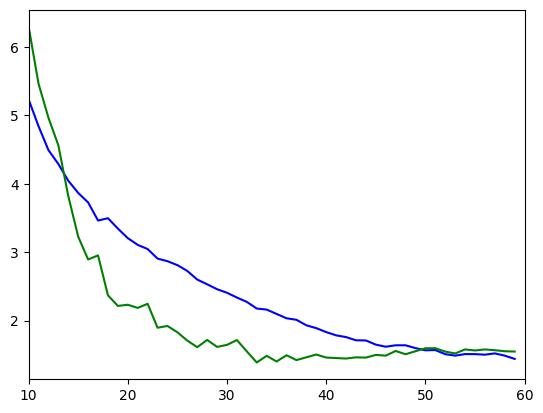

In [12]:
loss_plot(model.train_loss[10:], model.valid_loss[10:], x_axis=[10, len(model.valid_loss)])

In [15]:
# test
model = Model()
model.restore() # load best model during training
pred_y, true_y = model.predict(test_loader)

true_y = torch.FloatTensor(true_y)
pred_y = torch.FloatTensor(pred_y)

# pred_y = torch.unsqueeze(pred_y, dim=1)

print(pred_y.shape, true_y.shape)
test_mse = model.criterion(pred_y, true_y)
print('Test MSE : ',test_mse.item())

torch.Size([1529, 1]) torch.Size([1529, 1])
Test MSE :  1.318480134010315


In [39]:
class Base_Model(nn.Module):
    def __init__(self):
        super(Base_Model, self).__init__()
        self.device = "cuda:0" if torch.cuda.is_available() else "cpu"
        self.feature_map_channel = 320
        self.feature_map_h = 6
        self.feature_map_w = 10
        self.criterion = nn.MSELoss()
        self.efficient_net_channel1 = 1280
        self.efficient_net_channel2 = 1000

        self.fc1 = nn.Linear(20492, 400) # using image
        self.fc2 = nn.Linear(400, 20) # using image
        self.fc3 = nn.Linear(20, 1) # using image
 
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

        self.to(self.device)
    
    def forward(self, feature_map, title, meta):
        feature_map = feature_map.to(self.device)
        title = title.to(self.device)
        meta = meta.to(self.device)

        feature_map = torch.flatten(feature_map, start_dim=1)
        x = torch.cat([feature_map, title, meta], dim=1)

        x = self.fc1(x)
        x = self.relu(x)
        
        x = self.fc2(x)
        x = self.relu(x)

        x = self.fc3(x)
        x = self.relu(x)

        return x

    def train_(self, epochs, lr, train_loader, valid_loader, save_every):
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.parameters(), lr=lr)

        self.train_loss = []
        self.valid_loss = []

        best_mse = 1e100
        best_epoch = 1

        train_start = time.time()

        print("Model will be trained on {}\n".format(self.device))

        for epoch in range(1, epochs + 1):
            self.train()
            print("[Epoch {:3d} / {}]".format(epoch, epochs))

            epoch_start = time.time()
            epoch_loss = 0.0
            self.to(self.device)
            #training
            for batch_idx, batch_data in enumerate(notebooktqdm(train_loader, desc="Training")):
                batch_video_id, batch_image, batch_title, batch_meta, batch_target = batch_data
                batch_target = batch_target.to(self.device)
                
                self.optimizer.zero_grad()
                output = self.forward(batch_image, batch_title, batch_meta)
                loss = self.criterion(output, batch_target)
                loss.backward()
                self.optimizer.step()

                epoch_loss += loss.item()

            epoch_end = time.time()
            m, s = divmod(epoch_end - epoch_start, 60)

            epoch_loss /= len(train_loader)
            self.train_loss.append(epoch_loss)
            
            #validation
            with torch.no_grad():
                self.eval()
                true_y, pred_y = self.predict(valid_loader)                
                true_y = torch.FloatTensor(true_y)
                pred_y = torch.FloatTensor(pred_y)
                valid_loss = self.criterion(pred_y, true_y)
                self.valid_loss.append(valid_loss.item())

            print("Train MSE = {:.4f} | Valid MSE = {:.4f}".format(epoch_loss, valid_loss))
            print(f"Train Time: {m:.0f}m {s:.0f}s\n")

            valid_mse = valid_loss.item()
            if best_mse > valid_mse:
                print("=> Best Model Updated : Epoch = {}, Valid MSE = {:.4f}\n".format(epoch, valid_mse))
                best_mse = valid_mse
                best_epoch = epoch
                torch.save(self.state_dict(), "./model/best_model_epoch{}.pt".format(epoch))
            else:
                print()

            # save model for every ? epoch
            if (epoch % save_every) == 0:
                torch.save(self.state_dict(),"./model/epoch{}_train{:.4f}_valid{:.4f}.pt".format(epoch, epoch_loss, valid_mse))

        m, s = divmod(time.time() - train_start, 60)
        print("\nTraining Finished...!!")
        print("\nBest Valid MSE : %.2f at epoch %d" % (best_mse, best_epoch))
        print(f"Total Time: {m:.0f}m {s:.0f}s\nModel was trained on {self.device}!")

        torch.save(self.state_dict(),"./model/epoch{}_train{:.4f}_valid{:.4f}.pt".format(epoch, epoch_loss, valid_mse))
    
    def restore(self):
        with open("./best_model/best_model.pt", "rb") as f:
            state_dict = torch.load(f)
        self.load_state_dict(state_dict)

    def predict(self, dataloader):
        self.to(device)
        with torch.no_grad():
            self.eval()
            true_y = []
            pred_y = []
            for batch_video_id, batch_image, batch_title, batch_meta, batch_target in dataloader:
                batch_image = batch_image.to(device)
                batch_title = batch_title.to(device)
                batch_meta = batch_meta.to(device)
                pred = self.forward(batch_image, batch_title, batch_meta)
                true_y.append(batch_target.numpy())
                pred_y.append(pred.cpu().numpy())
            pred_y = np.concatenate(pred_y, axis=0)
            true_y = np.concatenate(true_y, axis=0)
        return true_y, pred_y #numpy array

    def plot(self):
        plt.plot(np.array(self.train_loss), "b")
        plt.plot(np.array(self.valid_loss), "g")
        plt.savefig("./graph.png")
        plt.show()

In [40]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

model_our = Model()
model_base = Base_Model()
print(get_n_params(model_our), get_n_params(model_base))


6295411 8205241


In [41]:
model_base.to(model_base.device)
model_base.train_(epochs, lr, train_loader, valid_loader, save_every)

Model will be trained on cpu

[Epoch   1 / 200]


Training:   0%|          | 0/194 [00:00<?, ?it/s]


KeyboardInterrupt

